In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from warnings import filterwarnings

In [2]:
filterwarnings(action='ignore')
plt.style.use('ggplot')

In [3]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [4]:
train_df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


## EDA

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### NaNs

#### Train set

In [5]:
train_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
train_df[train_df['question1'].isnull() == True]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [7]:
train_df[train_df['question2'].isnull() == True]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [8]:
train_df.drop(train_df[train_df['question2'].isnull() == True].index, inplace=True)
train_df.drop(train_df[train_df['question1'].isnull() == True].index, inplace=True)

#### test set

In [9]:
test_df.isnull().sum()

test_id      0
question1    4
question2    6
dtype: int64

In [10]:
test_df[test_df['question1'].isnull() == True]

,test_id,question1,question2
1046690,1046690,NaN,How I what can learn android app development?
1461432,1461432,NaN,How distinct can learn android app development?
2345796,"life in dublin?""",NaN,NaN
2679111,1461432,NaN,How distinct can learn android app development?


In [11]:
test_df[test_df['question2'].isnull() == True]

,test_id,question1,question2
379205,379205,How I can learn android app development?,NaN
817520,817520,How real can learn android app development?,NaN
943911,943911,How app development?,NaN
1270024,1270024,How I can learn app development?,NaN
2345796,"life in dublin?""",NaN,NaN
2487703,1270024,How I can learn app development?,NaN


In [56]:
## we'll take care of that later

### Target distribution

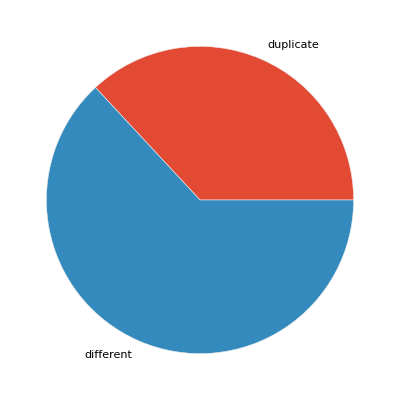

In [40]:
dist = [train_df[train_df['is_duplicate'] == 1]['is_duplicate'].count(
), train_df[train_df['is_duplicate'] == 0]['is_duplicate'].count()]

plt.pie(dist, labels=['duplicate', 'different'])
plt.show()

In [19]:
dist

[149263, 255024]